In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import tensorflow as tf
import keras
import keras.layers as layers
import keras.activations as activations
import numpy as np




2022-04-26 14:46:37.073039: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-26 14:46:37.073069: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [13]:
rng = np.random.default_rng()
fs = 10e3
N = 1e5
amp = 2 * np.sqrt(2)
noise_power = 0.01 * fs / 2
time = np.arange(N) / float(fs)
mod = 500*np.cos(2*np.pi*0.25*time)
carrier = amp * np.sin(2*np.pi*3e3*time + mod)
noise = rng.normal(scale=np.sqrt(noise_power),size=time.shape)
noise *= np.exp(-time/5)
x = carrier + noise

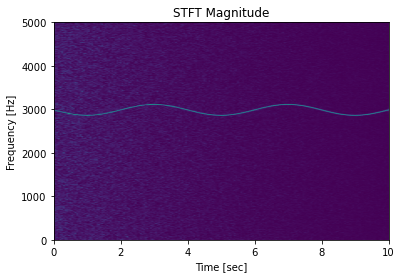

In [14]:
f, t, Zxx = signal.stft(x, fs, nperseg=1000)
plt.pcolormesh(t, f, np.abs(Zxx), vmin=0, vmax=amp, shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

## Construction des différents blocs du NN

In [15]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

#### 1-Construction de la Depthwise convolution

In [16]:
import keras
import tensorflow as tf
import keras.layers as layers
import keras.activations as activations
import numpy as np


2022-04-12 10:25:43.586942: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-12 10:25:43.586969: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [17]:
x = np.random.rand(7,128,1)
#print(x)
y = tf.keras.layers.Conv1D(32, 3, input_shape=[3,128])(x)
print(np.shape(y))


(7, 126, 32)


2022-04-12 10:25:46.313581: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-12 10:25:46.313614: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-12 10:25:46.313637: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sparekh-Precision-T3610): /proc/driver/nvidia/version does not exist


In [18]:
class DepthwiseSeparableConv1d(tf.keras.Model):
    def __init__(self, in_channels, out_channels, kernel_size, stride):


        super().__init__()

        shape = ([None, in_channels])
        self.kernel = kernel_size
        self.l1= tf.keras.Sequential()
        self.conv1d_1 = tf.keras.layers.Conv1D(out_channels , 1, input_shape = shape)
        self.norm1 = tf.keras.layers.BatchNormalization()
        self.relu1 = layers.Activation(activations.relu)

        self.conv1d_2 = layers.Conv1D(out_channels,kernel_size, input_shape =(None,out_channels),strides = stride, groups = out_channels)
        self.norm2 = tf.keras.layers.BatchNormalization()
        self.relu2 = layers.Activation(activations.relu)


    def call (self, x):

        x = self.l1(x)
        x = self.conv1d_1(x)
        x = self.norm1(x)
        x = self.relu1(x)
        print(np.shape(x))

        pad = np.zeros((np.shape(x)[0],self.kernel//2,np.shape(x)[2]))
        pad_x = np.concatenate((pad,x.numpy(),pad),axis=1)
        y = self.conv1d_2(pad_x)
        y = self.norm2(y)
        y = self.relu2(y)

        return y



In [19]:
dpconv = DepthwiseSeparableConv1d(128, 60, 4, 3)

y = dpconv(x)

print(np.shape(y))

(7, 128, 60)
(7, 43, 60)


In [20]:
x = np.zeros((7,2,60))
y =  np.zeros((7,128,60))

np.shape(np.concatenate((x,y),axis = 1))

(7, 130, 60)

#### 2-Construction du bloc GRU

In [21]:
## fonction de départ

class GRUBlock2(nn.Module):
    def __init__(self, in_channels, hidden_size, out_channels, bidirectional):
        super(GRUBlock, self).__init__()
        self.GRU = nn.GRU(in_channels, hidden_size, bidirectional=bidirectional)
        
        self.conv = nn.Sequential(nn.Conv1d(hidden_size * (2 if bidirectional==True else 1), out_channels, kernel_size = 1),
                    nn.BatchNorm1d(out_channels),
                    nn.ReLU(inplace=True))

    def forward(self, x):
        output,h = self.GRU(x)
        output = output.transpose(1,2)
        output = self.conv(output)
        return output

In [22]:
# Traduit en keras

class GRUBlock(keras.Model):
    def __init__(self, in_channels, hidden_size, out_channels, bidirectional):

        super(GRUBlock, self).__init__()



        self.GRU = layers.GRU(hidden_size)

        if bidirectional:
            self.bidir = layers.Bidirectional(self.GRU)
        else:
            self.bidir = self.GRU
        
        self.conv = keras.Sequential()

        #input = hidden_size * (2 if bidirectional==True else 1)
        self.conv.add(layers.Conv1D(out_channels, kernel_size = 1))
        self.conv.add(layers.BatchNormalization())
        self.conv.add(layers.Activation(activations.relu))

    def call(self, x):
        output,h = self.bidir(x)

        output = output.transpose(1,2)

        output = self.conv(output)

        return output

## 3 - Tr-CNN

### 3.1 - First Tr-CNN 

In [23]:
## Code de base

class FirstTrCNN2(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super(FirstTrCNN, self).__init__()
        self.FirstTrCNN = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=1),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True),
            nn.ConvTranspose1d(in_channels = out_channels,
                                out_channels = out_channels,
                                kernel_size = kernel_size,
                                stride = stride,
                                padding = stride//2),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self,x):
        return self.FirstTrCNN(x)

In [24]:
# Code keras

class FirstTrCNN(keras.Model):

    def __init__(self, in_channels, out_channels, kernel_size, stride):

        super(FirstTrCNN, self).__init__()

        self.kernel = kernel_size
        self.FirstTrCNN = keras.Sequential

        self.FirstTrCNN.add(layers.Conv1D(out_channels, kernel_size=1))
        self.FirstTrCNN.add(layers.Conv1D(out_channels, kernel_size=1))
        
        self.FirstTrCNN.add(layers.BatchNormalization())
        self.FirstTrCNN.add(layers.Activation(activations.relu))

        self.conv_trans = layers.Conv1DTranspose(out_channels,
                                kernel_size = kernel_size,
                                strides = stride)


        self.BN = layers.BatchNormalization()
        self.relu = layers.Activation(activations.relu)
        

    def call(self,x):

        y = FirstTrCNN(x)
        pad = np.zeros((np.shape(y)[0],self.kernel//2,np.shape(y)[2]))
        pad_y = np.concatenate((pad,y.numpy(),pad),axis=1)
        out = self.conv_trans(pad_y)
        out = self.relu(self.BN(out))
        return out

### 3.2 - Tr-CNN Block

In [26]:
## Code de base

class TrCNN(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super(TrCNN, self).__init__()
        self.TrCNN = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=1),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True),
            nn.ConvTranspose1d(in_channels = out_channels,
                                out_channels = out_channels,
                                kernel_size = kernel_size,
                                stride = stride,
                                padding = stride//2),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self,x1,x2):
        diffY = x2.size()[2] - x1.size()[2]
        x1 = F.pad(x1, [diffY // 2, diffY - diffY // 2, 0, 0])
        x = torch.cat((x1,x2),1)
        output = self.TrCNN(x)
        return output

In [27]:
# Implémentation keras

class TrCNN(keras.Model):

    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super(TrCNN, self).__init__()
        self.kernel = kernel_size
        self.conv1d = layers.Conv1D(out_channels, kernel_size=1)
        self.norm1 = layers.BatchNormalization()
        self.relu1 = layers.Activation(activations.relu)

        self.conv1dT = layers.Conv1DTranspose(out_channels, kernel, strides = stride)
        
        self.norm2 = layers.BatchNormalization()
        self.relu2 = layers.Activation(activations.relu)



    def call(self,x1,x2):

        diffY = x2.size()[2] - x1.size()[2]

        x1 = layers.ZeroPadding1D(x1, [diffY // 2, diffY - diffY // 2])

        x = layers.concatenate(axis=1)([x1,x2])
        output = self.TrCNN(x)
        return output

# Trainable PCEN

In [21]:


import librosa
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
import math

%matplotlib inline



In [8]:
slice_len   = 2
slice_count = 1
sr          = 44100
n_mels      = 256
fmin        = 20
hop_length  = int(sr/(n_mels/slice_len)) # ensures square mel-spectrogram slice
fmax        = sr//2

y = librosa.effects.trim(librosa.load('Sls.wav' , sr)[0])[0]

s = librosa.feature.melspectrogram(y, 
                                   sr         = sr,
                                   n_mels     = n_mels,
                                   hop_length = hop_length,
                                   n_fft      = n_mels*20,
                                   fmin       = fmin,
                                   fmax       = fmax)

/tmp/ipykernel_6177/803162767.py:9: FutureWarning: Pass sr=44100 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  y = librosa.effects.trim(librosa.load('Sls.wav' , sr)[0])[0]
/tmp/ipykernel_6177/803162767.py:11: FutureWarning: Pass y=[ 0.         0.        -0.0078125 ...  0.         0.         0.       ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  s = librosa.feature.melspectrogram(y,


In [13]:
gain          = 0.6
bias          = 0.1 
power         = 0.2 
time_constant = 0.4 
eps           = 1e-9

In [16]:
gain          = 0.6
bias          = 0.1 
power         = 0.2 
time_constant = 0.4 
eps           = 1e-9

time_constant = 0.4

power_to_db = librosa.power_to_db(s)

pcen_librosa = librosa.core.pcen(s, 
                                 sr            = sr,
                                 hop_length    = hop_length,
                                 gain          = gain,
                                 bias          = bias,
                                 power         = power,
                                 time_constant = time_constant,
                                 eps           = eps)

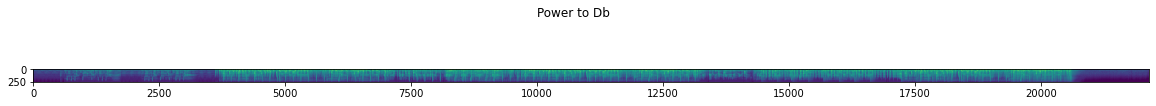

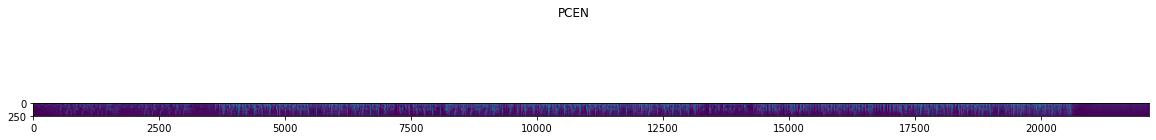

In [19]:
fig = plt.figure(figsize=(20,2))
fig.suptitle("Power to Db")
plt.imshow(power_to_db)


fig = plt.figure(figsize=(20,3))
fig.suptitle("PCEN")
plt.imshow(pcen_librosa)



In [37]:
A = tf.constant([[0.,2.],[3.,4.]])
B=tf.ones([2,2])
print(A-B)
C=A-1
print(tf.clip_by_value(A,B,C))

tf.Tensor(
[[-1.  1.]
 [ 2.  3.]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[1. 1.]
 [2. 3.]], shape=(2, 2), dtype=float32)


In [2]:
import Utils as ut

In [4]:
x = tf.constant(np.random.rand(654,256,4))

a = ut.sigma(x)
print(tf.shape(a))

tf.Tensor([654 256   4], shape=(3,), dtype=int32)
tf.Tensor([  4 654 256], shape=(3,), dtype=int32)


In [6]:
print(tf.divide(1, tf.abs(a[0]-a[1])))

tf.Tensor(
[[ 15.44976943 103.15095187   4.0616461  ...   3.27096334   5.79220559
    4.69472029]
 [  2.42576672   7.97116561  13.71294398 ... 108.65116698   3.37525997
    4.08707641]
 [  5.39173528   4.38256295   2.37785707 ... 140.95030184   4.03003848
   61.06770665]
 ...
 [  8.20135195   4.30403529 183.675118   ...  13.45891494  82.84398196
    5.84168541]
 [ 19.03962179   8.8374049   22.83311866 ...  42.63081138  16.53378055
    5.47178155]
 [  6.10240476   3.31114188   8.75153991 ...  51.16853394  10.81921983
   12.30190779]], shape=(654, 256), dtype=float64)
